In [3]:
%load_ext autoreload
%autoreload 2

import ncem
import scanpy as sc
import numpy as np
from scipy.spatial import KDTree

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.19.5 scipy==1.7.1 pandas==1.3.2 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.4 louvain==0.7.0 pynndescent==0.5.2


In [1]:
datadir = "/Users/anna.schaar/phd/datasets/"

In [78]:
scRNAseq = sc.read(datadir + "lu/fetal_liver.h5ad")

In [51]:
markers = list(set.intersection(set(scRNAseq.var_names), set(sorted_HSC.var_names)))

In [79]:
sorted_HSC = sc.read(datadir + "lu/sorted_HSC.h5ad")

In [82]:
sorted_HSC.obsm['test'] = sorted_HSC

In [84]:
sorted_HSC.obsm['test']

AnnData object with n_obs × n_vars = 6486 × 15899
    obs: 'n_counts', 'log_counts', 'n_genes', 'mt_frac'
    var: 'chozen_isoform', 'code', 'n_cells'
    obsm: 'test'

In [52]:
scRNAseq = scRNAseq[:, markers]
sorted_HSC= sorted_HSC[:, markers]

In [86]:
sc.pp.highly_variable_genes(scRNAseq)

In [87]:
hvg_scRNAseq = [x for i, x in enumerate(scRNAseq.var_names) if list(scRNAseq.var['highly_variable'])[i]]

In [55]:
sc.pp.highly_variable_genes(sorted_HSC)

Trying to set attribute `.uns` of view, copying.


In [69]:
hvg_sorted_HSC = [x for i, x in enumerate(sorted_HSC.var_names) if list(sorted_HSC.var['highly_variable'])[i] == True]

In [70]:
hvg_markers = list(set.intersection(set(hvg_scRNAseq), set(hvg_sorted_HSC)))

In [72]:
len(hvg_markers)

1436

In [73]:
xxx = sc.external.pp.mnn_correct(scRNAseq, sorted_HSC, var_subset=hvg_markers, do_concatenate=True)

Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 1: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


In [89]:
xxx

(AnnData object with n_obs × n_vars = 14274 × 14937
     obs: 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'batch'
     var: 'chozen_isoform', 'code', 'n_cells-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1',
 [0,
        new cell  ref cell  original batch
  0            7      3267               0
  1            7      2408               0
  2            7      7058               0
  3            7      3796               0
  4            7      2266               0
  ...        ...       ...             ...
  9876      6479       386               0
  9877      6479      4042               0
  9878      6479      4501               0
  9879      6483      4136               0
  9880      6483      1079               0
  
  [9881 rows x 3 columns]],
 None)

In [5]:
interpreter = ncem.interpretation.interpreter.InterpreterGraph()
interpreter.get_data(
    data_path=datadir + '/lu/',
    data_origin='luwt',
    radius=200,
    node_label_space_id='type',
    node_feature_space_id='standard',
)
print('\n Celldata metadata:', interpreter.data.celldata.uns['metadata'])


Loading data from raw files
registering celldata


/Users/anna.schaar/opt/miniconda3/envs/ncem/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


['AEC', 'Erythroid cell', 'Erythroid progenitor', 'Hepatocyte', 'MK', 'Macrophage', 'Myeloid', 'SEC', 'Unknown']
collecting image-wise celldata


 16%|█▌        | 22/140 [00:00<00:00, 215.23it/s]

adding graph-level covariates


100%|██████████| 140/140 [00:00<00:00, 226.97it/s]


Loaded 140 images with complete data from 1 patients over 40864 cells with 132 cell features and 9 distinct celltypes.
Mean of mean node degree per images across images: 16.576537

 Celldata metadata: {'lateral_resolution': 0.1079, 'fn': 'FinalClusteringResults 190517 WT.csv', 'image_col': 'FOV', 'pos_cols': ['Center_x', 'Center_y'], 'cluster_col': 'CellTypeID_new', 'cluster_col_preprocessed': 'CellTypeID_new_preprocessed'}


In [150]:
merfish = interpreter.data.celldata

In [6]:
merfish = interpreter.data.celldata

merfish_markers = list(merfish.var_names)
merfish_markers.remove('Fgf2')

merfish = merfish[:,merfish_markers]
sc.pp.normalize_total(merfish, target_sum=1e5)
sc.pp.log1p(merfish)

scRNAseq = scRNAseq[:,merfish_markers]

/Users/anna.schaar/opt/miniconda3/envs/ncem/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [7]:
imputed_adata = sc.external.pp.mnn_correct(scRNAseq, merfish, do_concatenate=False)

/Users/anna.schaar/opt/miniconda3/envs/ncem/lib/python3.8/site-packages/mnnpy/utils.py:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: No implementation of function Function(<function norm at 0x7fcc25b928b0>) found for signature:
 
 >>> norm(x=array(float32, 2d, A), axis=Literal[int](1))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'norm_impl': File: numba/np/linalg.py: Line 2352.
    With argument(s): '(x=array(float32, 2d, A), axis=int64)':
   Rejected as the implementation raised a specific error:
     TypeError: norm_impl() got an unexpected keyword argument 'x'
  raised from /Users/anna.schaar/opt/miniconda3/envs/ncem/lib/python3.8/site-packages/numba/core/typing/templates.py:710

During: resolving callee type: Function(<function norm at 0x7fcc25b928b0>)
During: typing of call at /Users/anna.schaar/opt/miniconda3/envs/ncem/lib/pyth

Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 1: processing batch 1
  Looking for MNNs...


/Users/anna.schaar/opt/miniconda3/envs/ncem/lib/python3.8/site-packages/mnnpy/utils.py:88: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "find_mutual_nn" failed type inference due to: non-precise type pyobject
During: typing of argument at /Users/anna.schaar/opt/miniconda3/envs/ncem/lib/python3.8/site-packages/mnnpy/utils.py (94)

File "../../../opt/miniconda3/envs/ncem/lib/python3.8/site-packages/mnnpy/utils.py", line 94:
def find_mutual_nn(data1, data2, k1, k2, n_jobs):
    <source elided>
    mutual_2 = []
    for index_2 in range(data2.shape[0]):
    ^

  @jit((float32[:, :], float32[:, :], int8, int8, int8))
/Users/anna.schaar/opt/miniconda3/envs/ncem/lib/python3.8/site-packages/numba/core/object_mode_passes.py:177: NumbaWarning: Function "find_mutual_nn" was compiled in object mode without forceobj=True.

File "../../../opt/miniconda3/envs/ncem/lib/python3.8/site-packages/mnnpy/utils.py", line 94:
def find_mutual_nn(data1, 

  Computing correction vectors...


/Users/anna.schaar/opt/miniconda3/envs/ncem/lib/python3.8/site-packages/mnnpy/utils.py:102: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "compute_correction" failed type inference due to: non-precise type pyobject
During: typing of argument at /Users/anna.schaar/opt/miniconda3/envs/ncem/lib/python3.8/site-packages/mnnpy/utils.py (107)

File "../../../opt/miniconda3/envs/ncem/lib/python3.8/site-packages/mnnpy/utils.py", line 107:
def compute_correction(data1, data2, mnn1, mnn2, data2_or_raw2, sigma):
    <source elided>
    vect_reduced = np.zeros((data2.shape[0], vect.shape[1]), dtype=np.float32)
    for index, ve in zip(mnn2, vect):
    ^

  @jit(float32[:, :](float32[:, :], float32[:, :], int32[:], int32[:], float32[:, :], float32))
/Users/anna.schaar/opt/miniconda3/envs/ncem/lib/python3.8/site-packages/numba/core/object_mode_passes.py:177: NumbaWarning: Function "compute_correction" was compiled in object mode without forceob

  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


In [8]:
imputed_merfish = imputed_adata[0][1]
imputed_scRNAseq = imputed_adata[0][0]

In [9]:
imputed_scRNAseq

View of AnnData object with n_obs × n_vars = 7788 × 131
    obs: 'n_counts', 'log_counts', 'n_genes', 'mt_frac'
    var: 'chozen_isoform', 'code', 'n_cells'

In [10]:
tree = KDTree(imputed_scRNAseq.X)
dd, ii = tree.query(imputed_merfish.X, k=25)

In [11]:
imputed_full_transciptome = []
for i in range(imputed_merfish.shape[0]):
    imputed_full_transciptome.append(np.mean(scRNAseq[ii[i]].X, axis=0)[np.newaxis, :])

In [12]:
imputed_full_transciptome = np.concatenate(imputed_full_transciptome)

In [13]:
from anndata import AnnData
import pandas as pd
merfish_full_transcriptome = AnnData(
    X=pd.DataFrame(imputed_full_transciptome, columns=scRNAseq.var_names), 
    obs=imputed_merfish.obs
)

In [14]:
merfish_full_transcriptome.shape

(40864, 131)

In [35]:
merfish_check = pd.DataFrame(merfish[:,merfish_markers].X, columns=merfish_markers)
merfish_check['CellTypeID_new_preprocessed'] = list(merfish.obs['CellTypeID_new_preprocessed'])

test_2 = pd.DataFrame(
    merfish_check.groupby('CellTypeID_new_preprocessed').mean().T.reset_index().rename(columns={'CellTypeID_new_preprocessed': 'index', 'index':'gene'}).set_index('gene').stack()
).rename(columns={0: 'expression'})
test_2['CellTypeID_new_preprocessed'] = test_2.index.get_level_values(1)
test_2['sample']='MERFISH'

In [36]:
merfish_ft_check = pd.DataFrame(merfish_full_transcriptome[:,merfish_markers].X, columns=merfish_markers)
merfish_ft_check['CellTypeID_new_preprocessed'] = list(merfish_full_transcriptome.obs['CellTypeID_new_preprocessed'])

test = pd.DataFrame(
    merfish_ft_check.groupby('CellTypeID_new_preprocessed').mean().T.reset_index().rename(columns={'CellTypeID_new_preprocessed': 'index', 'index':'gene'}).set_index('gene').stack()
).rename(columns={0: 'expression'})

test['CellTypeID_new_preprocessed'] = test.index.get_level_values(1)
test['sample']='imputed MERFISH'

In [37]:
check = pd.concat([test, test_2])

In [38]:
check = check[check['CellTypeID_new_preprocessed'] != 'Unknown']

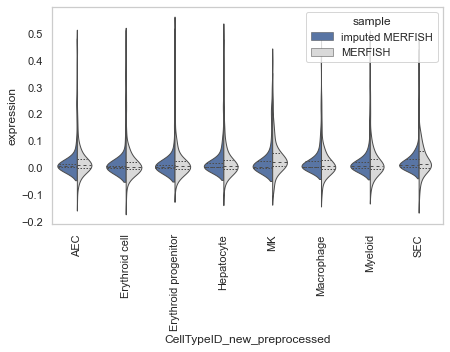

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(7,4))
sns.violinplot(
    data=check, x='CellTypeID_new_preprocessed', 
    y='expression', inner="quart", hue="sample", 
    split=True, linewidth=1, ax=ax,
    palette={"imputed MERFISH": "b", "MERFISH": ".85"}
)
ax.grid(False)
plt.xticks(rotation=90)
plt.show()

In [19]:
merfish_full_transcriptome.obsm['spatial']=np.array(merfish_full_transcriptome.obs[['Center_x', 'Center_y']])

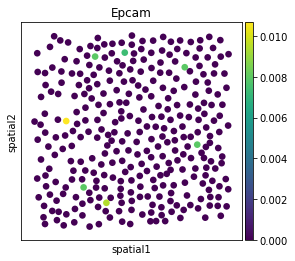

In [20]:
sc.pl.spatial(merfish_full_transcriptome[merfish_full_transcriptome.obs['FOV']==0], color=['Epcam'], spot_size=50)

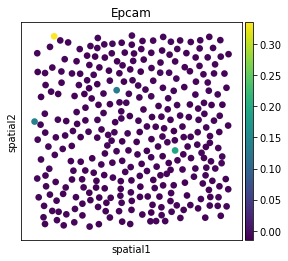

In [21]:
sc.pl.spatial(merfish[merfish.obs['FOV']==0], color=['Epcam'], spot_size=50)

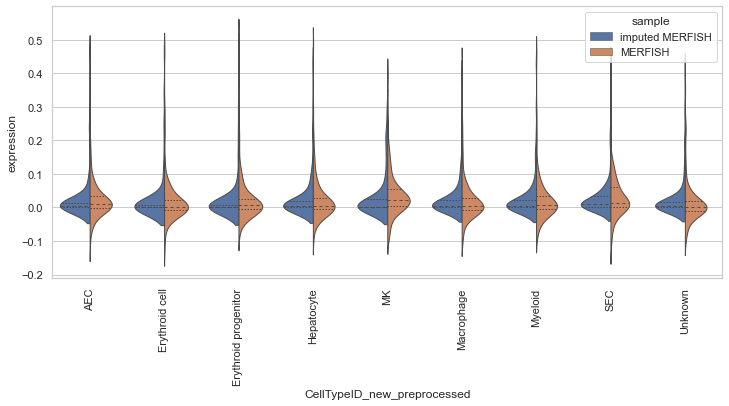

In [34]:
merfish_check = pd.DataFrame(imputed_merfish[:,merfish_markers].X, columns=merfish_markers)
merfish_check['CellTypeID_new_preprocessed'] = list(merfish.obs['CellTypeID_new_preprocessed'])

test_2 = pd.DataFrame(
    merfish_check.groupby('CellTypeID_new_preprocessed').mean().T.reset_index().rename(columns={'CellTypeID_new_preprocessed': 'index', 'index':'gene'}).set_index('gene').stack()
).rename(columns={0: 'expression'})
test_2['CellTypeID_new_preprocessed'] = test_2.index.get_level_values(1)
test_2['sample']='MERFISH'

merfish_ft_check = pd.DataFrame(merfish_full_transcriptome[:,merfish_markers].X, columns=merfish_markers)
merfish_ft_check['CellTypeID_new_preprocessed'] = list(merfish_full_transcriptome.obs['CellTypeID_new_preprocessed'])

test = pd.DataFrame(
    merfish_ft_check.groupby('CellTypeID_new_preprocessed').mean().T.reset_index().rename(columns={'CellTypeID_new_preprocessed': 'index', 'index':'gene'}).set_index('gene').stack()
).rename(columns={0: 'expression'})

test['CellTypeID_new_preprocessed'] = test.index.get_level_values(1)
test['sample']='imputed MERFISH'

check = pd.concat([test, test_2])

fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.violinplot(data=check, x='CellTypeID_new_preprocessed', y='expression', inner="quart", hue="sample", split=True, linewidth=1,ax=ax)
plt.xticks(rotation=90)
plt.show()